# Apprentissage supervisé - Régression

Autre grande catégorie de l'apprentissage supervisé : la régression. Le principe est très simple, on chercher à trouver la courbe optimale permettant de prévoir la valeur de sortie à partie d'une ou plusieurs valeurs d'entrées. Il existe plusieurs algorithmes de régressions, mais celui qui va nous intéresser concerne la "régression linéaire", elle est de deux types :
- Une valeur d'entrée -> Régression linéaire simple
- Plusieurs valeurs d'entrée -> Régression linéaire multiple (la plus courante)

![Image regression](../_images/regression.jpg)

### But du TP
- Découvrir la régression linéaire simple
- Tester différents modèles de régression linéaire

## Régression linéaire simple

La plus simple à utiliser mais la moins courante, la régression linéaire simple consiste à trouver la droite correspondant à l'équation suivante :
$$ y = ax + b $$
A partir de notre jeu de données qui ressemble à quelque chose comme ceci
![Image regression](../_images/dataframe-linear.jpg)

Nous allons utiliser un autre classique du Machine Learning : logements.csv, c'est un dataset qui contient une surface et le loyer, notre but va donc être de trouver la courbe optimale permettant de prévoir la surface en fonction d'un loyer (on peut aussi choisir de faire l'inverse). Encore une fois, numpy, matplotlib.pyplot, pandas et scikit-learn vont être de précieux atouts (voir les précédentes pratiques si vous avez oublié ce que font ces outils).

# Avant-propos - Pour les utilisateurs de Google colab

Petit apparté pour les utilisateurs de google colab. Pour utiliser la méthode `pd.read_csv()`, il faudra rajouter quelques lignes de codes supplémentaires pour pouvoir charger un fichier, les voici.

```python
# Première cellule jupyter
from google.colab import files
uploaded = files.upload()
```

```python
# Seconde cellule jupyter
import io
# Très important : le nom du fichier passé en paramètre de la fonction "uploaded" doit avoir le même nom que le fichier que vous avez uploadé
df = pd.read_csv(io.BytesIO(uploaded['nom-du-fichier-uploader.csv']))
```

- [Voir plus  d'informations sur le chargement de fichiers externes avec Google colab](https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92)

# Phase 1 : Chargement des données

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

logements_df_src = pd.read_csv("datasets/slr-logements.csv")
logements_df = logements_df_src.copy()

On remarque donc que notre jeu de données est composé de deux colonnes "loyer" et "surface". Notre régression étant linéaire, nous en concluons que "loyer" est la valeur d'entrée et "surface", celle de sortie. Notre équation sera donc de la forme suivante :
$$ surface = a(loyer) + b $$
scikit-learn va nous aider à trouver les valeurs de "a" et "b". Mais avant, phase 2 : exploration des données

# Phase 2 : Exploration des données

Notre dataset étant relativement simple, on va avant tout chercher ces choses principalement :
- S'il y a des valeurs manquantes. `df.isnull().sum()`
- Le format des données. `df.dtypes`
- Les valeurs min/max. `df.describe()`
- S'il y a des données aberrantes dans nos valeurs d'entrées. `df["nom_de_la_colonne"].std()`

### Les données aberrantes (outliers en anglais)
Dans un jeu de données où les valeurs numériques ont une très grande importance, il faut faire très attention aux données aberrantes, une donnée aberrante est une donnée qui pourrait potentiellement fausser notre modèle d'apprentissage notamment pour les regressions, algorithmes où les variables sont quantitatives (des nombres). Pour savoir s'il y a des valeurs aberrantes deux choix s'offrent à nous :
- Calculer l'écart-type, soit l'écart entre deux valeurs, plus il est grand, plus les valeurs sont disparates
- Afficher un graphique type nuage de points

Quelque soit la méthode il est important de vérifier la présence de ces données, à défaut de les supprimer / remplacer. Notez qu'il existe des modèles qui permettent d'être plus ou moins tolérant aux données aberrantes, c'est le cas du HuberRegressor. Mais ce n'est pas forcément la meilleure des méthodes.
- [Voir documentation de HuberRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.HuberRegressor.html)

## A vous de coder

'Ecart type de notre colonne loyer : 2201.364353113282'

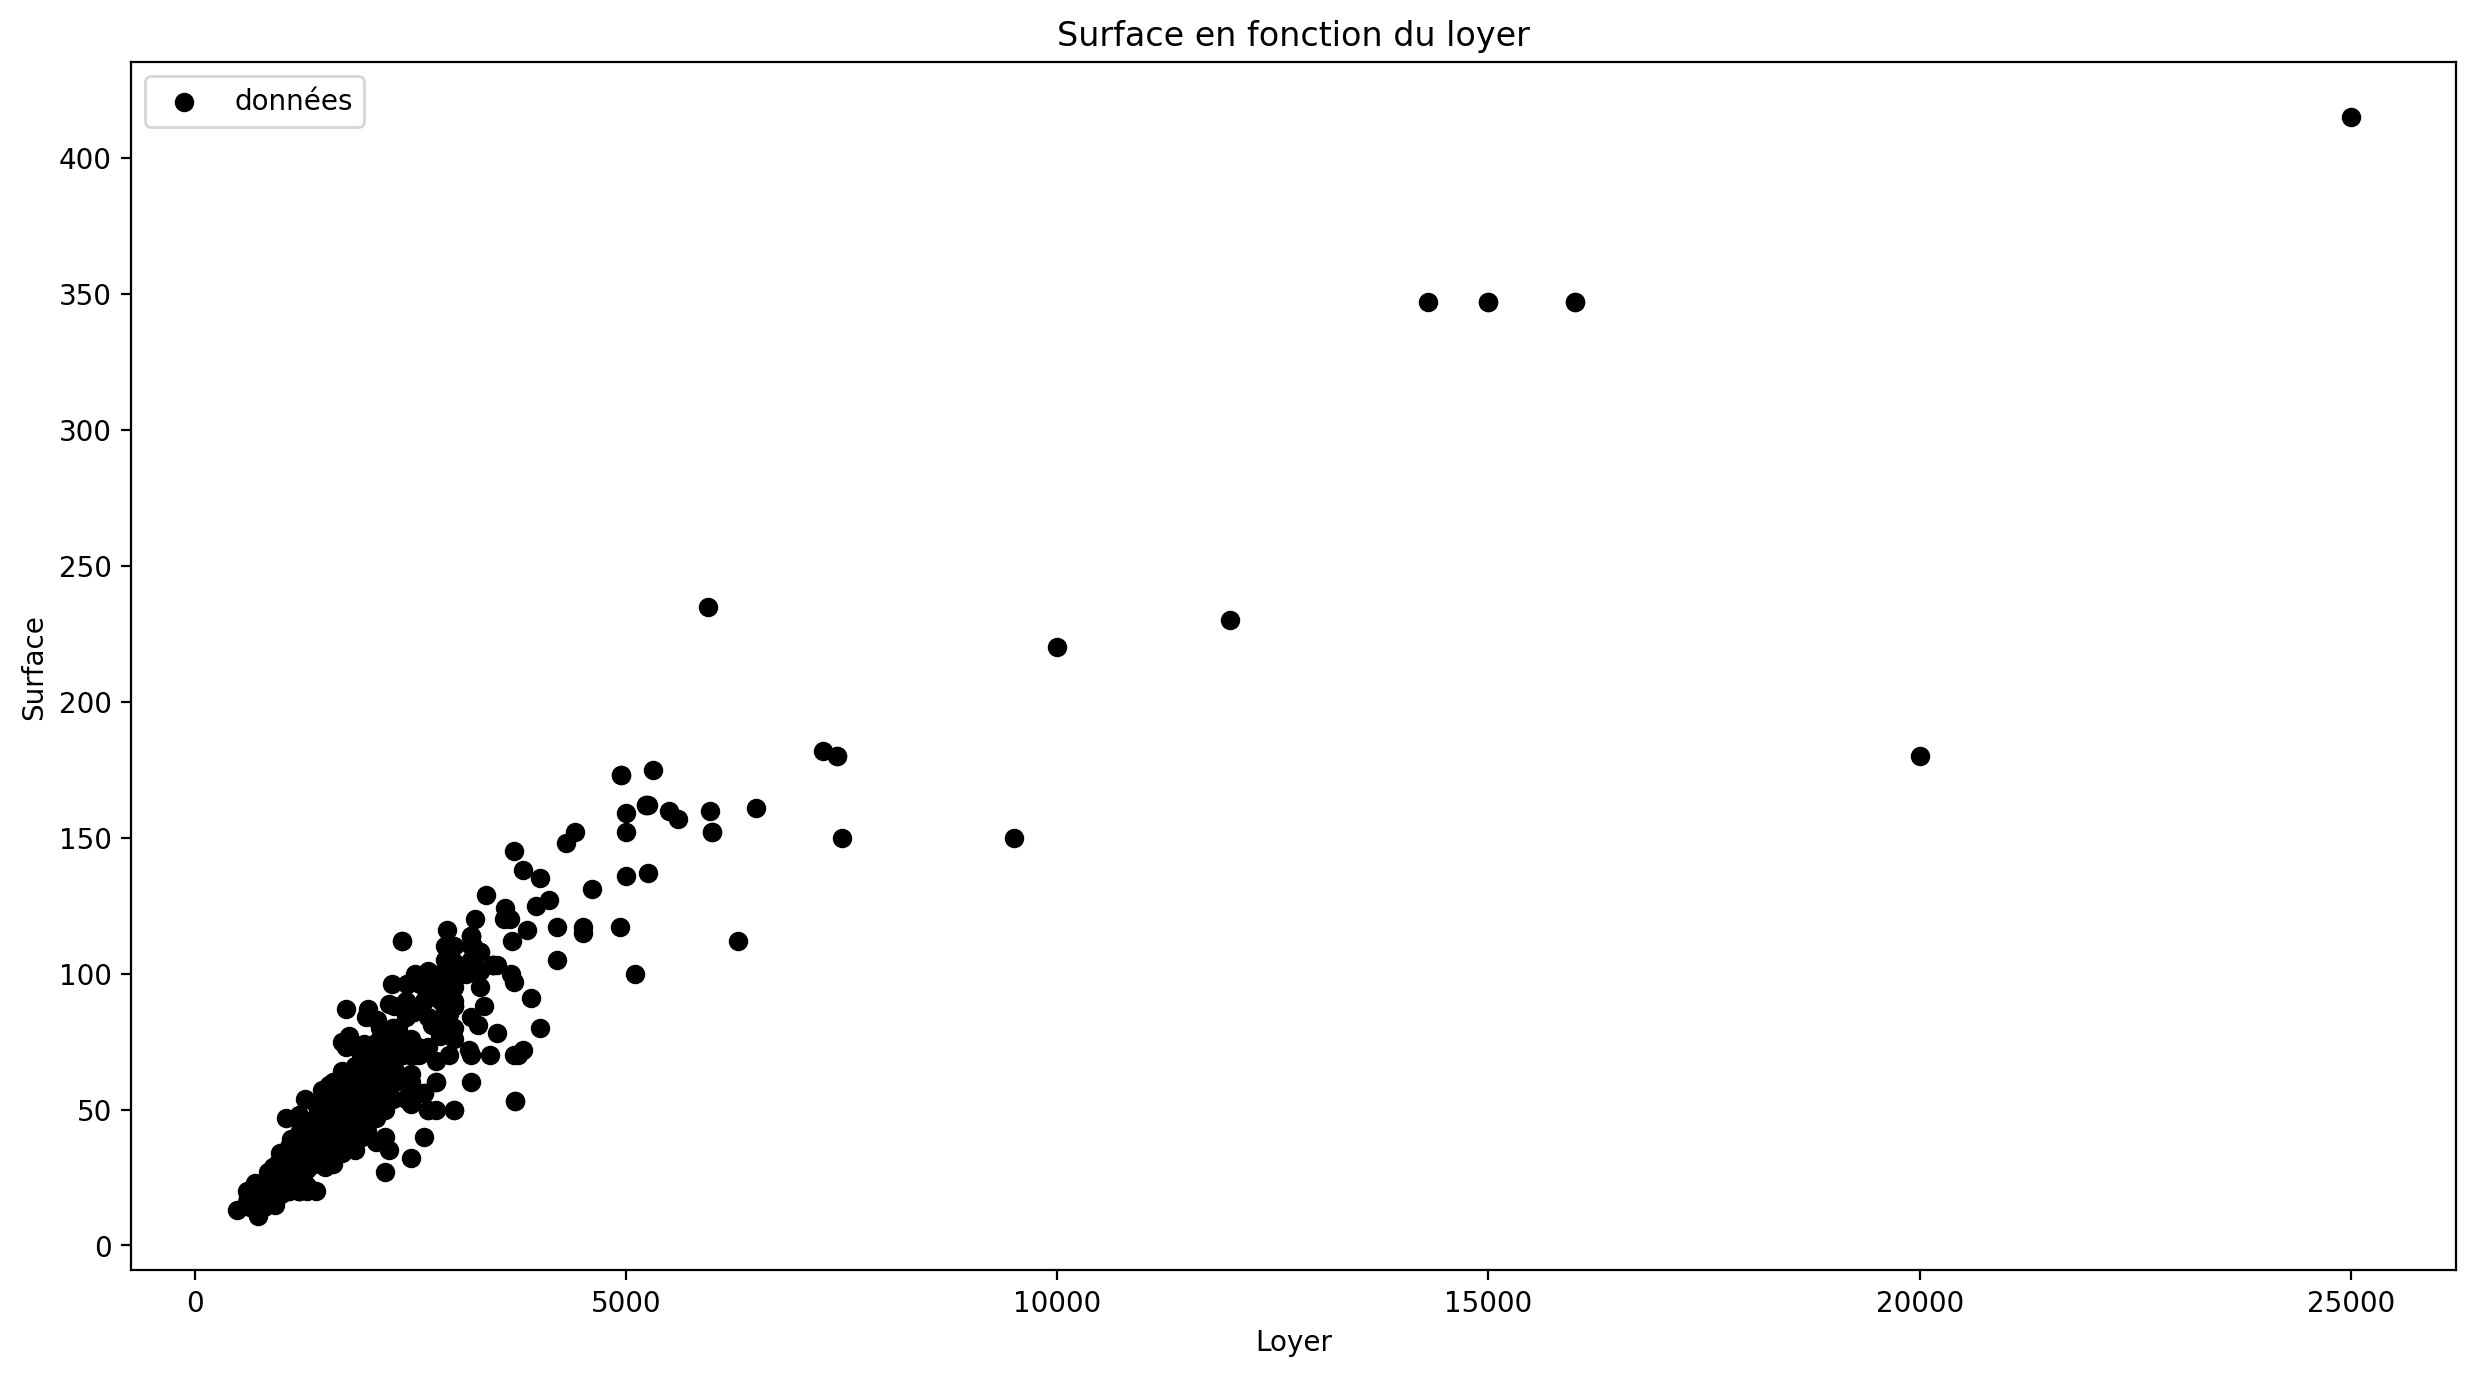

In [2]:
# - Quel est le format de nos données ?
# - Est-ce qu'il y a des valeurs aberrantes ?
# - Quelles sont les valeurs mix/max ?

# - Est-ce qu'il y a des valeurs aberrantes ?
ecart_type = logements_df["loyer"].std()
display(f"Ecart type de notre colonne loyer : {ecart_type}")
# > 2201.364353113282 - Est assez élevé, ça pourra nous jouer des tours

# L'ordre des lignes est très important, la taille du graphique doit être définie en premier
# Plus la valeur de dpi est grande, 
# plus il sera possible de zoomer dans le graphique (double-click)

plt.figure(figsize=(15, 8), dpi=200) 
plt.title('Surface en fonction du loyer')
plt.scatter(
    x = logements_df["loyer"], 
    y = logements_df["surface"], 
    color='black', 
    label="données"
)
plt.xlabel("Loyer")
plt.ylabel("Surface")
plt.legend()

# Phase 3 : Nettoyage / formattage des données

Notre jeu de données possède des données beaucoup aberrantes, nous allons donc y remédier pour retirer les valeurs aberrantes nous allons supprimer toutes les valeurs pour toutes les features (ici juste le loyer) dont la valeur est 1.5x inférieure au premier quartile (Q1) ou 1.5x supérieure au troisième quartile (Q3).
$$ ValeurAberranteBasse = Q1 - 1.5 * IQR $$
$$ ValeurAberranteHaute = Q1 + 1.5 * IQR $$
IQR ? Ceci signifie InterQuartile Range, c'est la soustration entre Q3 et Q1.
$$ IQR = Q3 - Q1 $$

Heureusement pour nous, pandas peut faire ces calculs pour nous.

- [Plus d'informations sur l'IQR (Écart interquartile)](https://fr.wikipedia.org/wiki/%C3%89cart_interquartile)

1345.0

848.1308408513714

Text(0, 0.5, 'Surface')

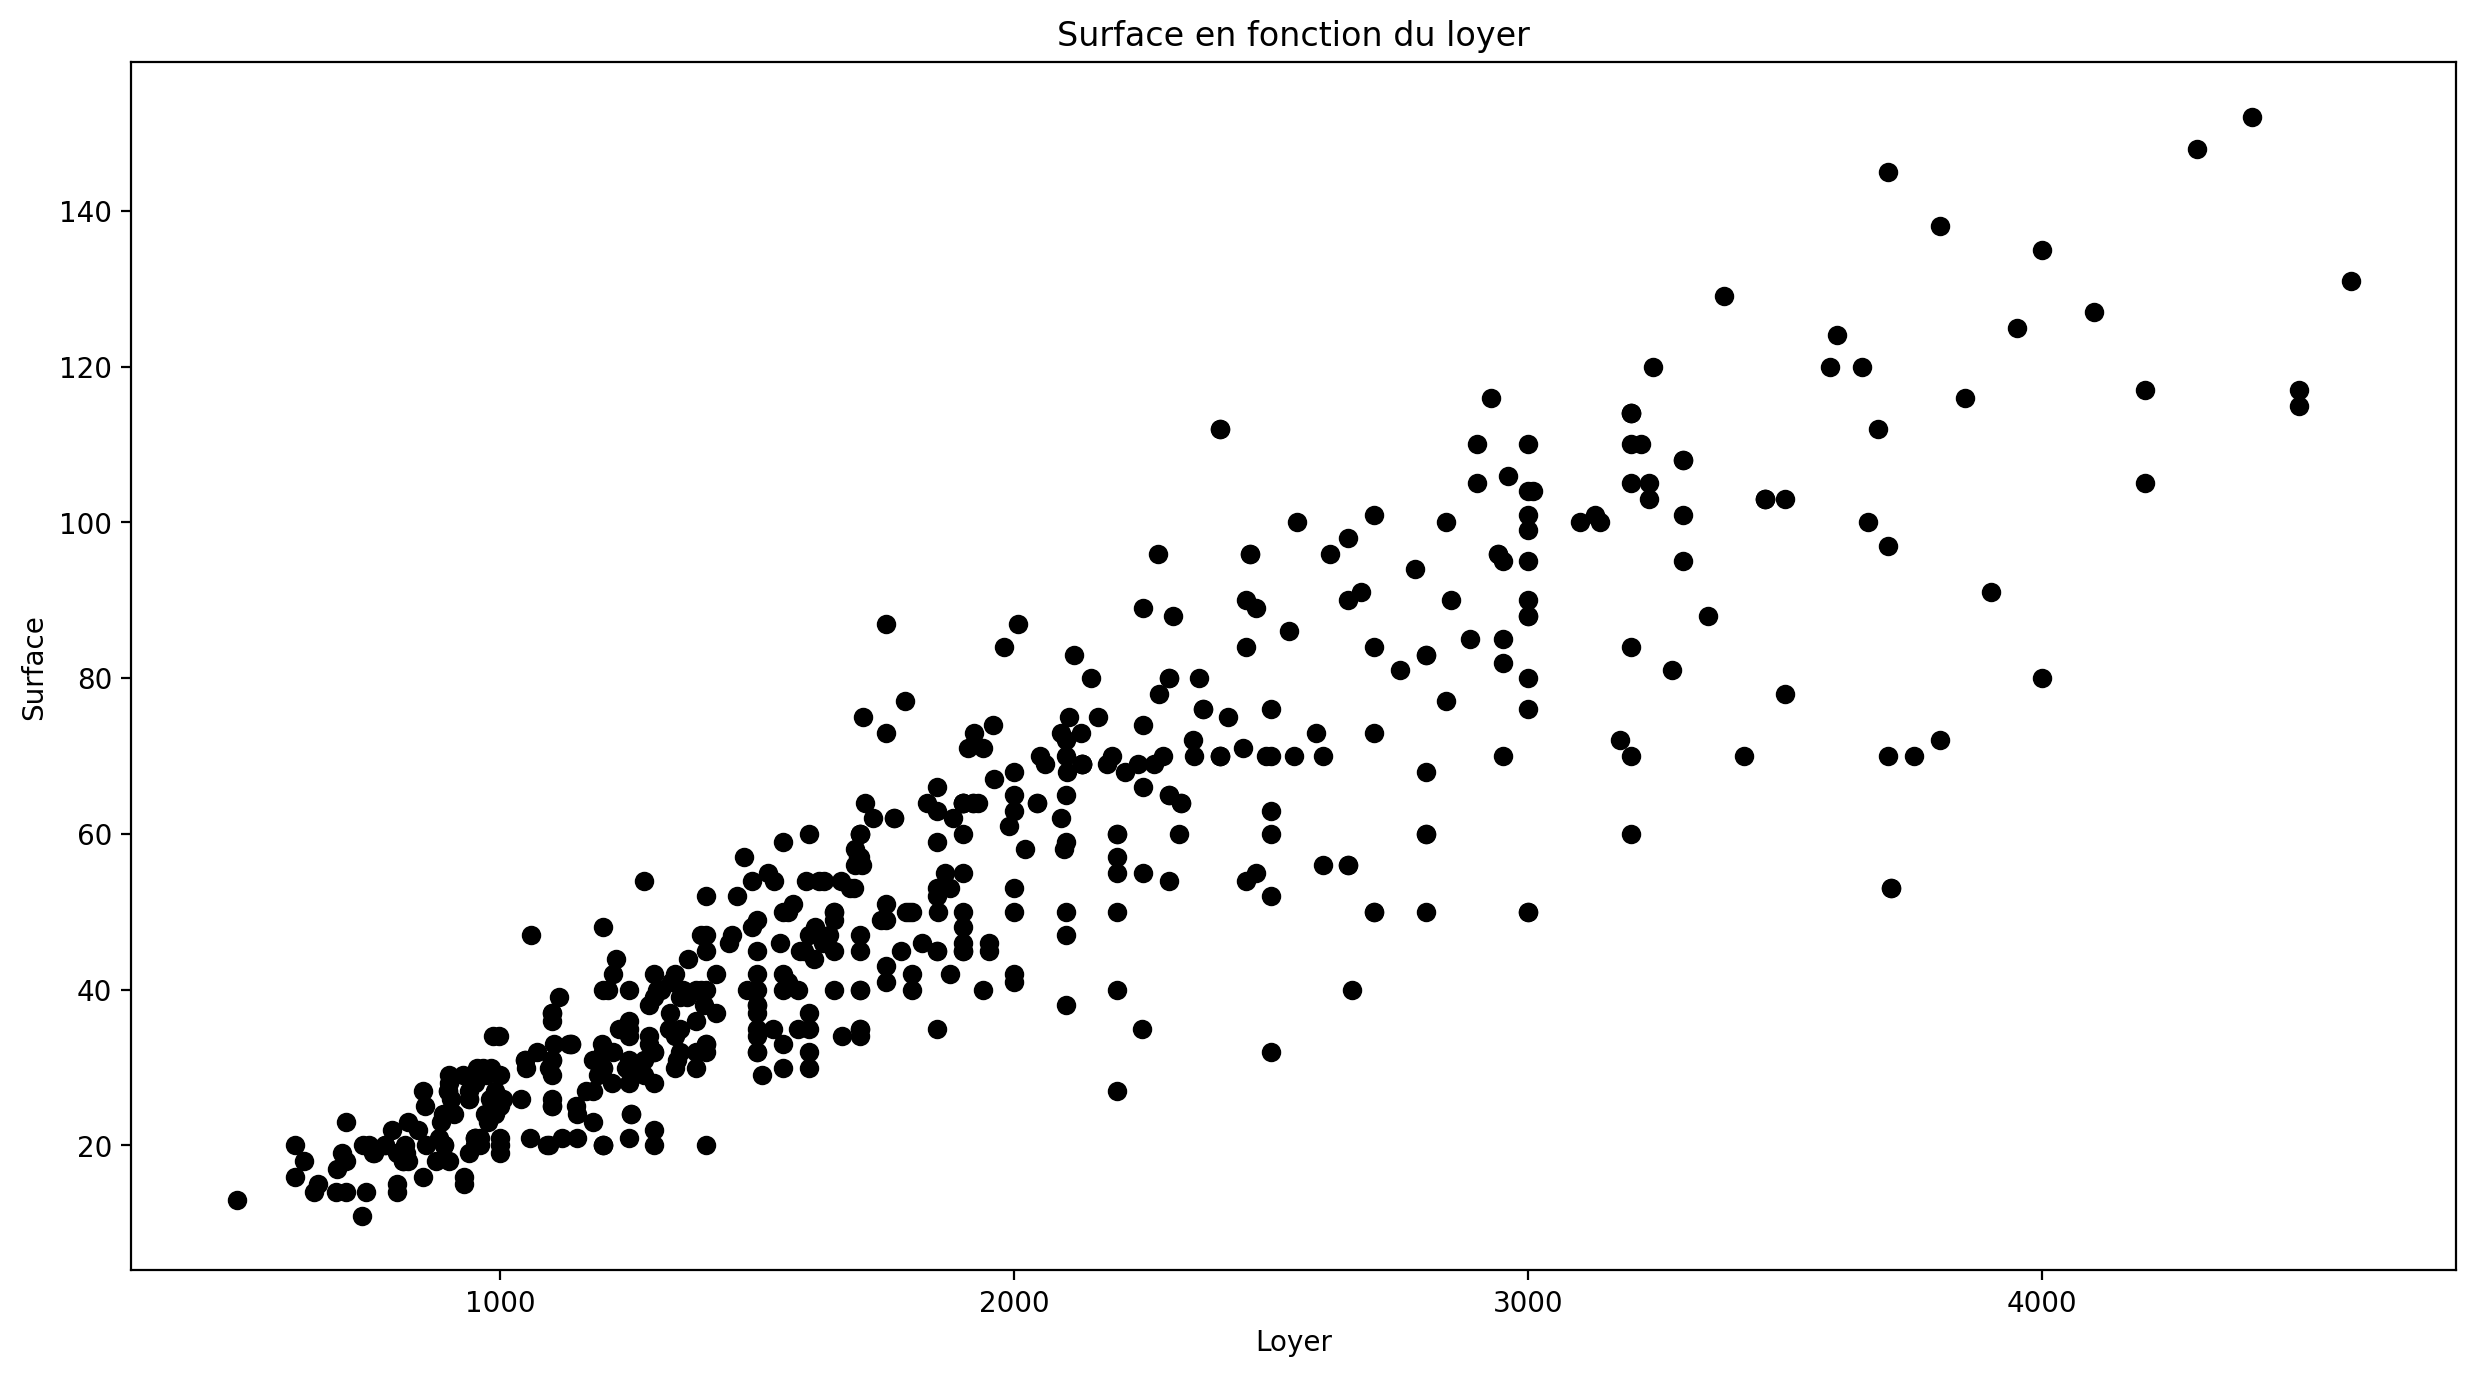

In [3]:
# pandas propose une méthode pour calculer les quartiles
Q1 = logements_df['loyer'].quantile(0.25) # Premier quartile
Q3 = logements_df['loyer'].quantile(0.75) # Troisième quartile
IQR = Q3 - Q1 # On calcule IQR
display(IQR)
# Nouvelle méthode "query", elle nous permet de filtrer les éléments de façon plus naturelle
logements_df.query('(@Q1 - 1.5 * @IQR) <= loyer <= (@Q3 + 1.5 * @IQR)', inplace=True)
display(logements_df["loyer"].std())
# Normalement notre écartype devrait être beaucoup plus petit, donc nos valeurs sont beaucoup moins disparates
# Nos calculs seront beaucoup moins soumis aux erreurs, notre apprentissage sera moins prompt aux erreurs

# La ligne précédente aurait pu être écrite de la façon suivante
# logements_df[(logements_df['loyer'] >= (Q1 - 1.5 * IQR)) & (logements_df['loyer'] <= (Q3 + 1.5 * IQR))]
# display(logements_df["loyer"].std())

# Avant de continuer, nous allons revoir notre graphique

plt.figure(figsize=(15, 8), dpi=200) 
plt.title('Surface en fonction du loyer')
plt.scatter(x = logements_df["loyer"], y = logements_df["surface"], color='black', label="données")
plt.xlabel("Loyer")
plt.ylabel("Surface")

Que constatez-vous ?

# Phase 4 : Modélisation

Nous allons utiliser scikit-learn et la régression linéaire via la ligne de code suivante `from sklearn.linear_model import LinearRegression`.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

liste_feat = logements_df[["surface"]]
sortie = logements_df['loyer']

# Pour rappel, il faut entrainer notre modèle ET le tester, 
# on va donc faire notre jeu de test et notre jeu d'entraînement au sein même de notre dataset
# grâce à la fonction train_test_split
# On applique la loi du 80/20. 80 % de données d'entraînement et 20% de test pour valider notre modèle
ratio_donnees_test = 0.2
# Par convention, les variables contenant les features sont précédées par un X majuscule (car plusieurs entrées)
# les variables de sortie un y minuscule (car une seule entrée)
X_entrainement, X_test, y_entrainement, y_test = train_test_split(
    liste_feat, 
    sortie,
    test_size=ratio_donnees_test
)

In [5]:
# On commence par instancier notre regression linéaire
reg_lin = LinearRegression()

# On entraine notre modèle avec la méthode fit
reg_lin.fit(X_entrainement, y_entrainement)

# Et on test notre modèle sur nos 20 % de données de test
surface_pred = reg_lin.predict(X_test)

# On peut comparer nos prédictions avec notre données de test (donc les valeurs cibles) grâce à un DataFrame
df = pd.DataFrame({'Surface cible': y_test, 'Surface prédite': surface_pred})
df

,Surface cible,Surface prédite
64,1800,1780.531419
424,637,819.038372
392,990,1166.244194
475,885,1059.411634
450,2290,2314.694223
...,...,...
461,1550,1326.493035
181,1218,1192.952334
52,1700,1513.450017
396,1250,1192.952334


##### Qu'observons-nous ?

Nous avons donc prédit la valeur de notre loyer en fonction de la surface. **Ce sont des prédictions** rien ne nous dit que ça sera la même chose en vrai, l'idée est d'avoir un ordre d'idée. Toutefois, il est possible de calculer un score, il permet d'évaluer notamment le taux de réussite des prédictions étant donnée que , il existe plusieurs façon de le faire.
Pour ce TP, nous allons nous limiter qu'à la méthode `.score()` de notre modèle. Exemple `model.score()`. Plus il va être prochaine de 1, plus de notre modèle sera bon au niveau des prédictions.

### A vous de coder
- Calculez et affichez le score de notre modèle
- Affichez ce score en pourcentage

N'oubliez pas la fonction `display()` pour afficher les données.

Avant de finir, on va quand même tracer notre droite et afficher notre équation, c'est ce que nous cherchions à faire.

Text(120, 2700, 'y=26.71*x + 445.12')

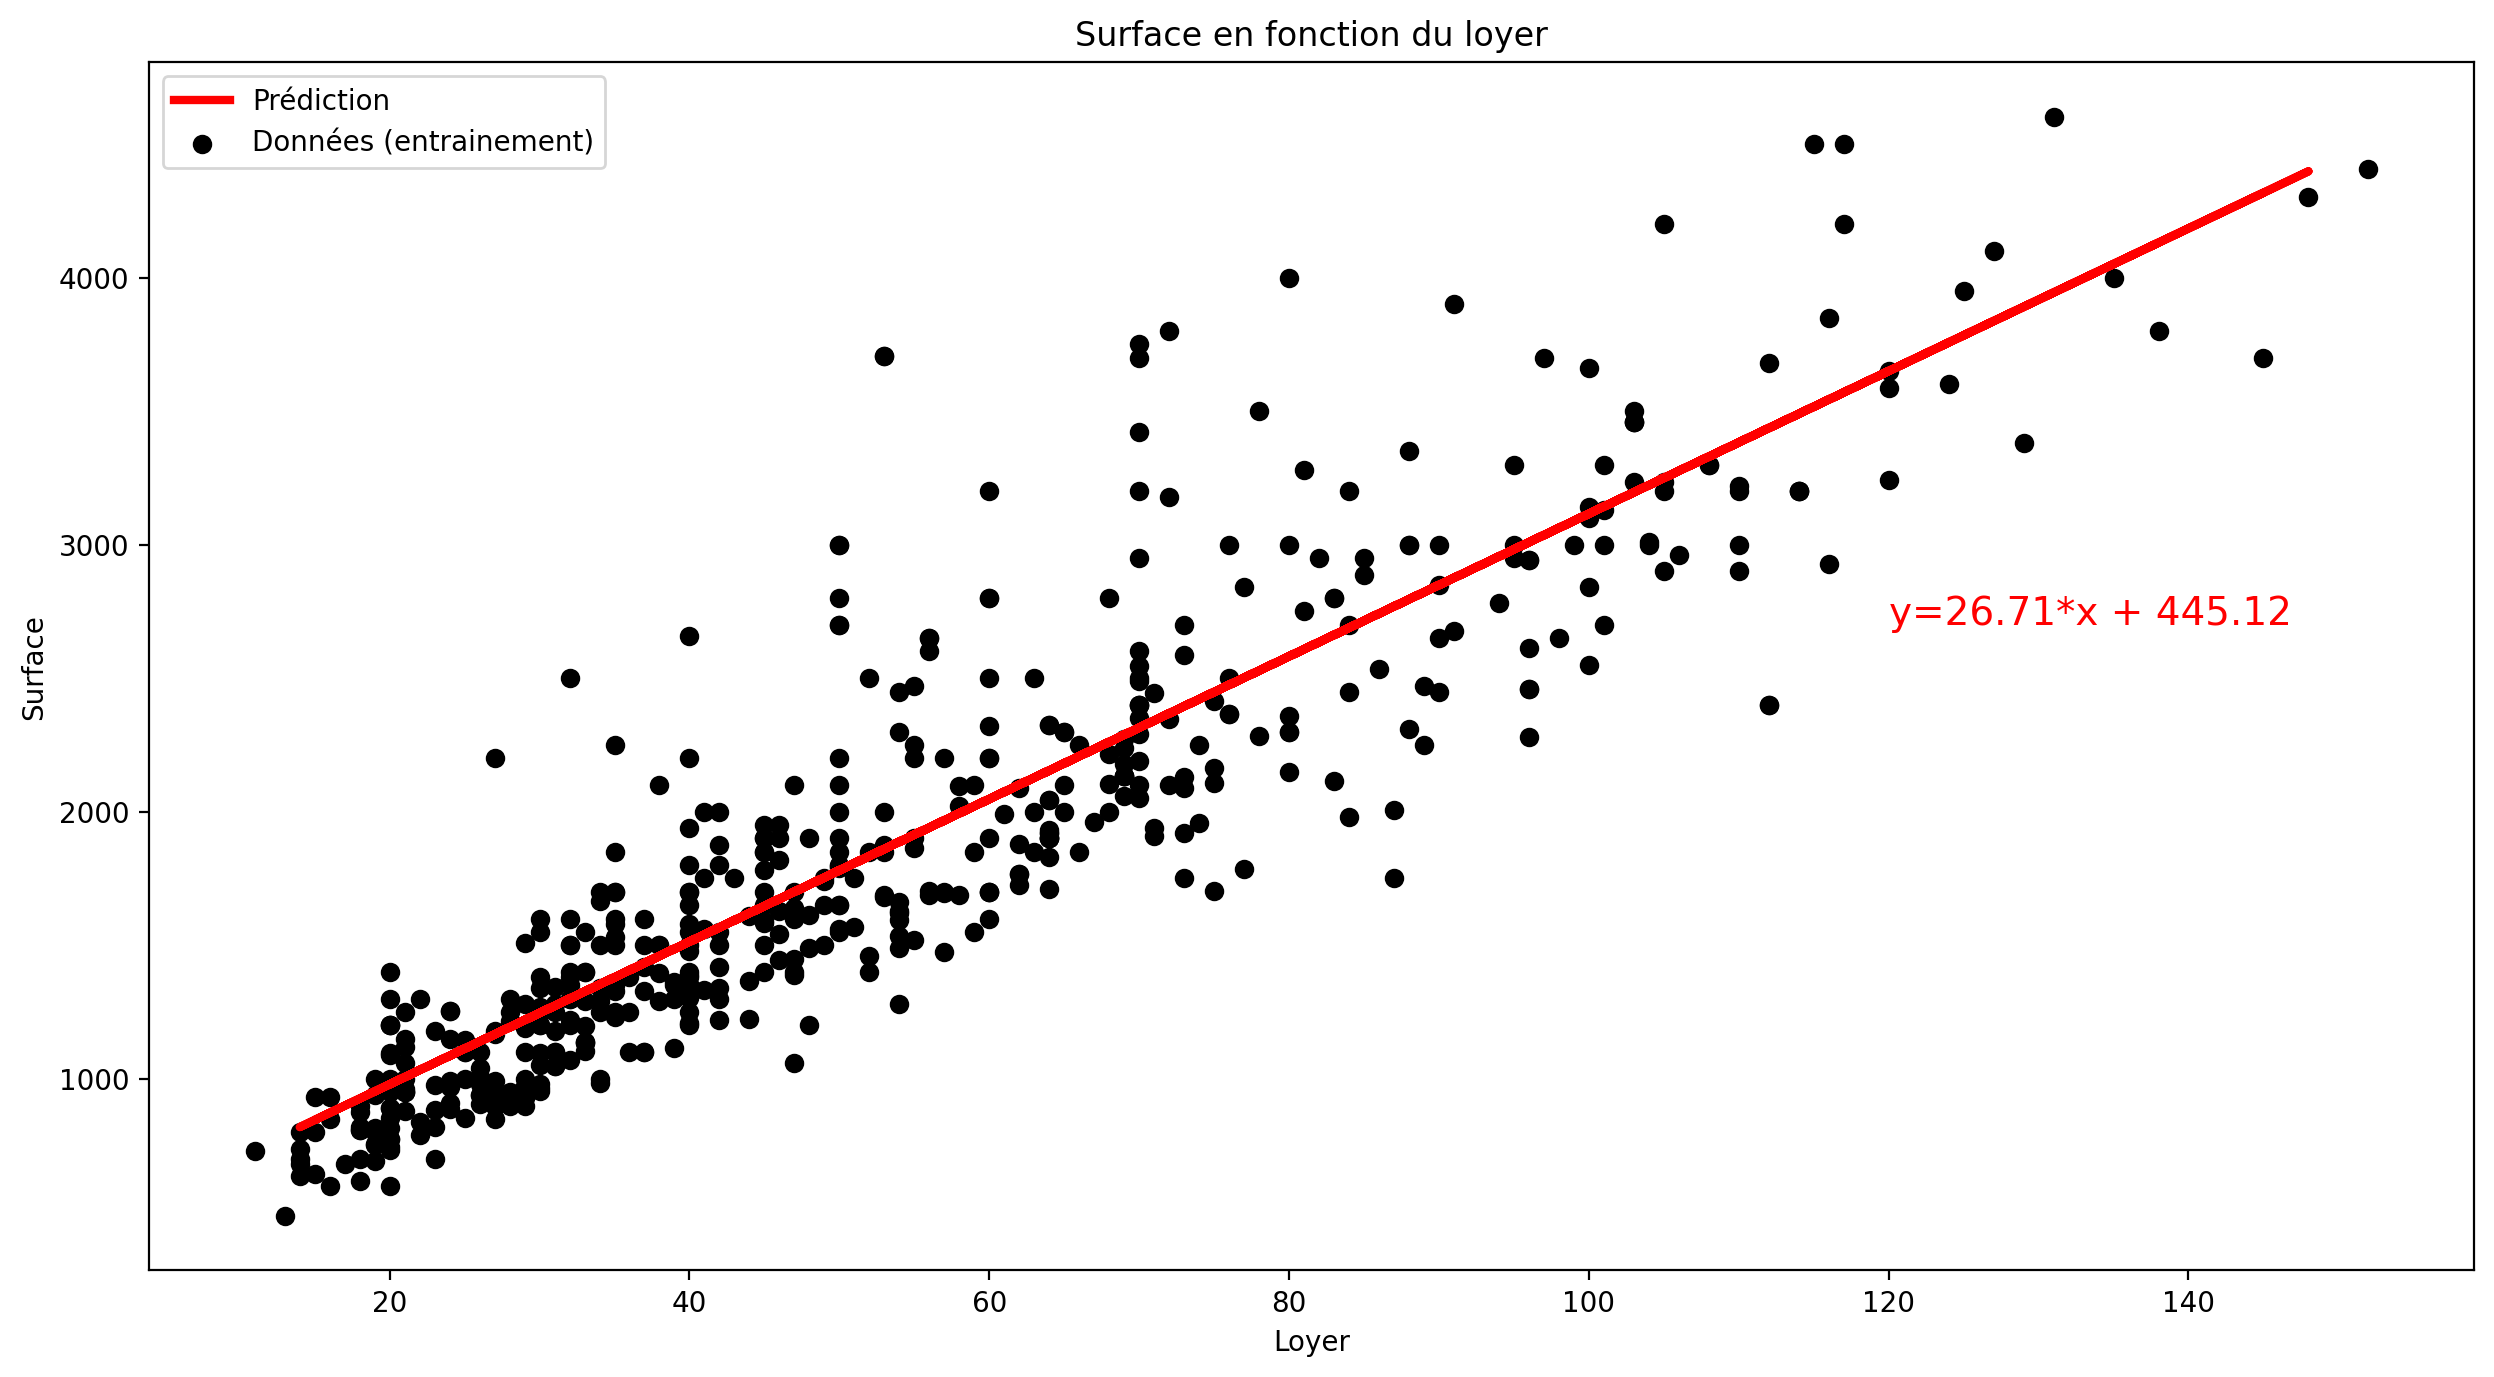

In [6]:
plt.figure(figsize=(15, 8), dpi=200) 
plt.title('Surface en fonction du loyer')
plt.scatter(x = logements_df["surface"], y = logements_df["loyer"], color='black', label="Données (entrainement)")
plt.plot(X_test, surface_pred, color='red', linewidth=3, label="Prédiction")
plt.xlabel("Loyer")
plt.ylabel("Surface")
plt.legend()
plt.text(120, 2700, 'y={:.2f}*x + {:.2f}'.format(reg_lin.coef_[0], reg_lin.intercept_), color='red', size=14)

Voilà nous avons notre graphique. On remarquera que notre graphique possède désormais une courbe, cette dernière est censée passer au milieu de tous les points et donc être la plus représentative de notre jeu de données. Pour obtenir l'équation de la courbe ($ y = ax + b $ où y est la surface et x le loyer), il faut utiliser les propriétés "coef_" et "intercept_" de la classe "LinearRegression" après avoir appelé la fonction "fit()".

In [7]:
display(f"Le coefficient directeur est {reg_lin.coef_[0]}") # a de ax + b
display(f"L'ordonnée à l'origine est {reg_lin.intercept_}") # b de ax +b 

'Le coefficient directeur est 26.708140190755135'

"L'ordonnée à l'origine est 445.1244091540725"

Notre équation est donc (peu ou prou)
$$ Loyer = 25.736019860465877  \times Surface + 483.7077158452598 $$

On remarquera que la propriété "coef_" retourne un tableau. Pourquoi ? Tout simplement parce que la classe LinearRegression peut également être utilisée pour une régression linéaire multiple (avec plusieurs variables d'entrées). Notre regression linéaire étant simple, il n'y a qu'un seul coefficient directeur.

Notez que ce résultat peut être validé par numpy et sa fonction `polyfit()`
```python
modele = np.polyfit(logements_df["surface"], logements_df["loyer"], 1)
display(modele)
```

Pour terminer, on va refaire cet exercice mais avec HuberRegressor pour voir les différences, car oui, le travail de data-scientifique c'est aussi la comparaison de modèles (en plus de la préparation des données), ce n'est pas uniquement trouver les meilleures valeurs pour nos hyperparamètres.

Pourquoi ce modèle plutôt qu'un autre ? Il n'y a pas de réelle raison, il faut juste savoir que l'HuberRegressor permet de faire varier sa sensibilité aux données aberrantes, et il peut même nous retourner les données qu'il juge aberrante dans ses résultats.

In [8]:
# On commence importer notre classe HuberRegressor
from sklearn.linear_model import HuberRegressor

# puis par instancier notre regression huber
reg_huber = HuberRegressor()

#Le reste ne change pas, on entraîne notre modèle avec 
# les mêmes données pour pouvoir comparer correctement les scores de nos deux modèles
reg_huber.fit(X_entrainement, y_entrainement)

# Et enfin, on fait notre prédiction. 
surface_pred_huber = reg_huber.predict(X_test)

# On stocke le score de notre modèle pour comparer sa performance face à un autre modèle
display(f"Le coefficient directeur est {reg_huber.coef_[0]}") # a de ax + b
display(f"L'ordonnée à l'origine est {reg_huber.intercept_}") # b de ax + b 

# On retourne un dataframe avec les données de la régression
df = pd.DataFrame({
    'Surface cible': y_test, 
    'Surface prédite (pred. linéaire)': surface_pred,
    'Surface (pred. huber)': surface_pred_huber, 
})
display(df)

# Et on n'oublie pas le score :
score_reg_huber = round(reg_huber.score(X_test, y_test) * 100, 2)
display(f"Score de notre modèle: {score_reg_huber}%")

'Le coefficient directeur est 26.561447145820388'

"L'ordonnée à l'origine est 401.4223055609612"

,Surface cible,Surface prédite (pred. linéaire),Surface (pred. huber)
64,1800,1780.531419,1729.494663
424,637,819.038372,773.282566
392,990,1166.244194,1118.581378
475,885,1059.411634,1012.335590
450,2290,2314.694223,2260.723606
...,...,...,...
461,1550,1326.493035,1277.950061
181,1218,1192.952334,1145.142826
52,1700,1513.450017,1463.880191
396,1250,1192.952334,1145.142826


'Score de notre modèle: 80.46%'

##### Qu'observons-nous ?

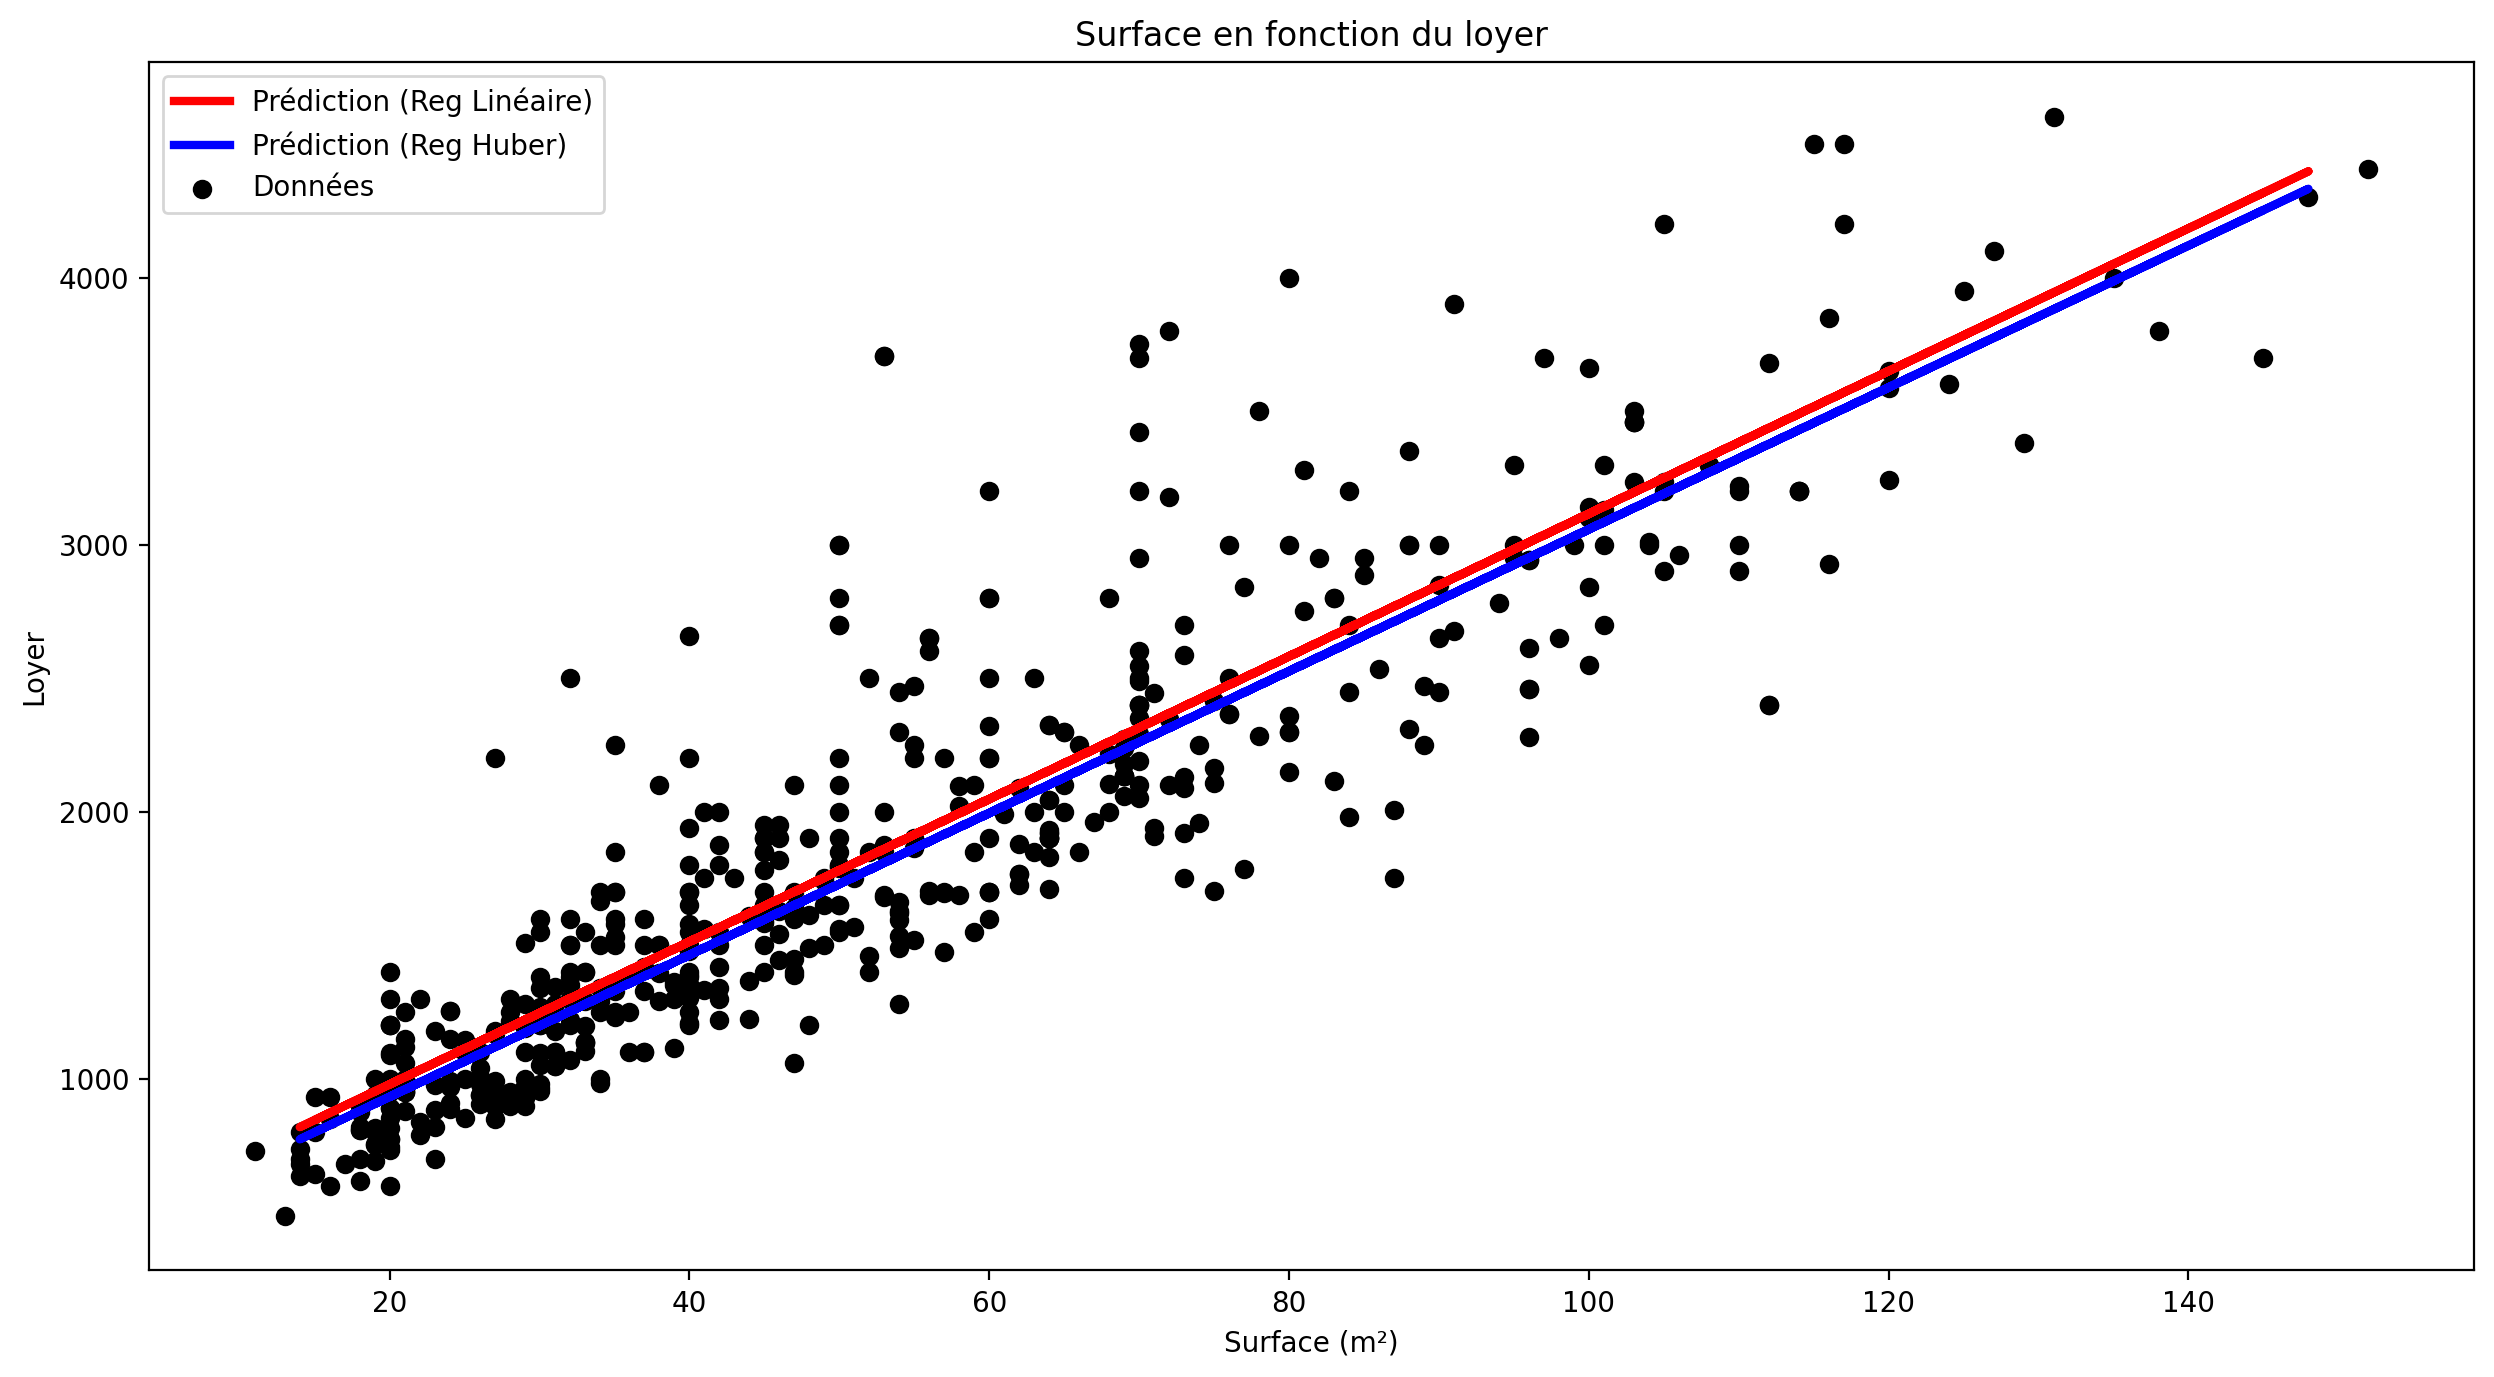

In [9]:
# On affiche notre graphique
plt.figure(figsize=(15, 8), dpi=200) 
plt.title('Surface en fonction du loyer')
plt.scatter(x = logements_df["surface"], y = logements_df["loyer"], color='black', label="Données")

plt.plot(X_test, surface_pred, color='red', linewidth=3, label="Prédiction (Reg Linéaire)")
plt.plot(X_test, surface_pred_huber, color='blue', linewidth=3, label="Prédiction (Reg Huber)")

plt.ylabel("Loyer")
plt.xlabel("Surface (m²)")
plt.legend()

Notez que la classe HuberRegressor possède une propriété `outliers_`, elle permet de faire remonter les valeurs aberrantes sous forme d'un masque. 

Essayons !

In [10]:
# On récupére les valeurs de la propriété

liste_valeurs_aberrantes = reg_huber.outliers_
display(liste_valeurs_aberrantes[:20:])

array([False, False, False, False,  True, False, False, False,  True,
       False,  True,  True, False, False, False, False, False, False,
        True, False])

```python
array([False, False, False,  True,  True, False, False, False, False,
        True,  True, False, False, False, False, False, False, False,
       False, False])
```
Vous devez avoir le résultat ci-dessus en sortie (sortie limitée aux vingt premières entrées). Notre tableau est donc un masque booléen, ceci signifie donc que notre Regression Huberienne a signalé les valeurs aberrantes ou non via la valeur True (valeur aberrante) et la valeur False (valeur non-aberrante).

Première étape : Explorer notre tableau.

- Combien il y a de valeurs aberrantes ?
- Quel est le ratio de valeurs aberrantes ?

### A vous de coder 
N'oubliez pas d'utiliser la fonction `display()` pour afficher les résultats.

In [11]:
# - Combien il y a de valeurs aberrantes ?

# - Quel est le ratio de valeurs aberrantes / valeurs non-aberrantes ?
# Ici nous sommes dans une cas de filtre pour rappel, pour filtre un tableau, il nous faut appliquer la syntaxe suivante
# tableau[tableau <ma condition>]
# Et c'est la fonction len() qui nous retourne le nombre d'éléments d'un liste/dataframe

Voilà, nous avons vu dans les grandes lignes la regression linéaire simple, il y a bien évidemment d'autres modèles que nous pourrions utiliser. Mais travailler sur une régression linéaire simple est assez rare dans le monde "réel". C'est pourquoi dans la prochaine partie, nous allons voir la régression linéaire multiple. Beaucoup plus en phase avec des besoins métiers réels.

## Pour terminer

- Ecrire une fonction prenant en paramètre une surface et retourne le loyer avec les paramètres de la régression linéaire
- Ecrire une fonction prenant en paramètre une surface et retourne le loyer avec les paramètres de la regression huberienne

In [12]:
# Ecrire une fonction prenant en paramètre une surface et retourne le loyer avec les paramètres de la régression linéaire

# Ecrire une fonction prenant en paramètre une surface et retourne le loyer avec les paramètres de la regression huberienne

### Pour aller plus loin

- Il y a un dataset slr-hubble_data.csv dans le dossier de la ressource, essayez de faire la même chose. (Travaillez dans un autre notebook)